In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

The approach of this notebook is to engineer features from the other datasets

In [2]:
# let's load the datasets
# we'd use the trainfeature_engineered1 file as our train file going on
app_train = pd.read_csv('../input/feature-engineering-1/trainfeature_engineered1.csv')
app_test = pd.read_csv('../input/feature-engineering-1/testfeature_engineered1.csv')

In [4]:
app_train.shape, app_test.shape

((307511, 336), (48744, 335))

In [5]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bb_balance_STATUS_X_mean_mean,client_bb_balance_STATUS_X_mean_max,client_bb_balance_STATUS_X_mean_min,client_bb_balance_STATUS_X_mean_sum,client_bb_balance_STATUS_X_sum_count,client_bb_balance_STATUS_X_sum_mean,client_bb_balance_STATUS_X_sum_max,client_bb_balance_STATUS_X_sum_min,client_bb_balance_STATUS_X_sum_sum,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.161932,0.5,0.0,1.295455,8.0,1.875,3.0,0.0,15.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Functions for feature aggregations

In [6]:
# function to convert data types
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
            new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [7]:
# function to plot kde
plt.style.use('fivethirtyeight')
def plot_kde(col, df):
    corr = df['TARGET'].corr(df[col])
    avg_repaid = df.loc[df['TARGET'] == 0, col].median()
    avg_notrepaid = df.loc[df['TARGET'] == 1, col].median()
    
    print(f"The correlation between {col} and the TARGET is {corr}")
    print(f"Median value for loan that was not repaid = {round(avg_notrepaid, 2)}")
    print(f"Median value for loan that was repaid = {round(avg_repaid, 2)}")
    
    plt.figure(figsize=(10, 6)) 
    sns.kdeplot(df.loc[df['TARGET'] == 0, col], label='target == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, col], label='target == 1')
    
    plt.title(f"Distribution of {col} by Target Value")
    plt.xlabel(f"{col}")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout(h_pad = 2.5)

In [8]:
def numeric_agg(df,cols, group_var, df_name):
    """Performs statistical aggregates(mean, sum etc) on the dataframes
    Args: 
        df:  the dataframe to perform the statisical aggregates on
        cols: the columns to aggregate on
        group_var: the column to groupby
        df_name : the name of dataframe to rename the columns
  Returns: 
          df_agg: the df of statistical aggregates
          """  
    df_agg = df[cols].groupby(group_var, as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index() # perfoms the statistical aggregates
    columns = [group_var]
    
    for feature in df_agg.columns.levels[0]:
        if feature != group_var: 
            for x in df_agg.columns.levels[1][:-1]:
                columns.append(f"{df_name}_{feature}_{x}")
                
    df_agg.columns = columns # rename the columns
    # let's remove redundant values
    # Remove the columns with all redundant values
    #_, idx = np.unique(df_agg, axis = 1, return_index=True)
    #df_agg = df_agg.iloc[:, idx]
    return df_agg

In [9]:
def encode_categorical(df, group_var, df_name):
    """Encodes the categorical variables in the dataframe
  Args: 
        df:  the dataframe to encode
        cols: the columns to aggregate on
        group_var: the column to groupby
        df_name : the name of dataframe to rename the columns
  Returns: 
        categorical_agg: the df of statistical aggregates of categorical columns
          """ 
    df_categorical = pd.get_dummies(df.select_dtypes(include='category'))
    df_categorical[group_var] = df[group_var] # add the key back
    categorical_agg = df_categorical.groupby(group_var, as_index = False).agg(['mean', 'sum']).reset_index()
    
    columns = [group_var]
    for feature in categorical_agg.columns.levels[0]:
        if feature != group_var: 
            for x in categorical_agg.columns.levels[1][:-1]:
                columns.append(f"{df_name}_{feature}_{x}")
                
    categorical_agg.columns = columns
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical_agg, axis = 1, return_index = True)
    categorical_agg = categorical_agg.iloc[:, idx]
    return categorical_agg

In [10]:
# for features added to the dataset, let's see the correlations
def columns_corr_target(columns):
    """Function computes the linear correlation of the features created with the TARGET
  We have to merge the created columns to the train before we can use this function
  Args: 
        columns: the new features added to the dataframe"""
    corrs = []
    for column in columns:
        corr = app_train['TARGET'].corr(app_train[column])
        corrs.append((column, corr))
        
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True) 
    print(corrs[:15])

## Credit Card Balance

In [11]:
credit_balance = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
credit_balance = convert_types(credit_balance, print_info = True)
credit_balance.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [12]:
credit_temp = credit_balance.drop(columns=['SK_ID_PREV']) # we don't aggregate on SK_ID_PREV
columns = credit_temp.select_dtypes(exclude='object').columns

credit_numeric = numeric_agg(credit_balance.drop(columns=['SK_ID_PREV']), columns, 'SK_ID_CURR', 'credit')

In [13]:
credit_numeric.head()

,SK_ID_CURR,credit_MONTHS_BALANCE_count,credit_MONTHS_BALANCE_mean,credit_MONTHS_BALANCE_max,credit_MONTHS_BALANCE_min,credit_MONTHS_BALANCE_sum,credit_AMT_BALANCE_count,credit_AMT_BALANCE_mean,credit_AMT_BALANCE_max,credit_AMT_BALANCE_min,...,credit_SK_DPD_count,credit_SK_DPD_mean,credit_SK_DPD_max,credit_SK_DPD_min,credit_SK_DPD_sum,credit_SK_DPD_DEF_count,credit_SK_DPD_DEF_mean,credit_SK_DPD_DEF_max,credit_SK_DPD_DEF_min,credit_SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.00000,0.0,...,6,0.000000,0,0,0,6,0.000000,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.109375,189000.00000,0.0,...,74,0.000000,0,0,0,74,0.000000,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919922,161420.21875,0.0,...,96,0.010417,1,0,1,96,0.010417,1,0,1
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.00000,0.0,...,17,0.000000,0,0,0,17,0.000000,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.00000,0.0,...,8,0.000000,0,0,0,8,0.000000,0,0,0


In [14]:
# let's encode its categorical features
credit_categorical = encode_categorical(credit_balance, 'SK_ID_CURR',  'credit')

In [15]:
credit_categorical.head()

,credit_NAME_CONTRACT_STATUS_Approved_mean,credit_NAME_CONTRACT_STATUS_Approved_sum,credit_NAME_CONTRACT_STATUS_Demand_mean,credit_NAME_CONTRACT_STATUS_Demand_sum,credit_NAME_CONTRACT_STATUS_Refused_mean,credit_NAME_CONTRACT_STATUS_Refused_sum,credit_NAME_CONTRACT_STATUS_Sent proposal_mean,credit_NAME_CONTRACT_STATUS_Sent proposal_sum,credit_NAME_CONTRACT_STATUS_Signed_mean,credit_NAME_CONTRACT_STATUS_Signed_sum,credit_NAME_CONTRACT_STATUS_Completed_mean,credit_NAME_CONTRACT_STATUS_Completed_sum,credit_NAME_CONTRACT_STATUS_Active_mean,credit_NAME_CONTRACT_STATUS_Active_sum,SK_ID_CURR
0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,6,100006
1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,74,100011
2,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,96,100013
3,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.588235,10,0.411765,7,100021
4,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,8,100023


In [16]:
# let's merger these datasets
credit_features = credit_numeric.merge(credit_categorical, on='SK_ID_CURR', how='inner')
credit_features.shape

(103558, 115)

In [17]:
# let's merge them on the train and test datasets
app_train = app_train.merge(credit_features, on='SK_ID_CURR', how='left') 
app_test = app_test.merge(credit_features, on='SK_ID_CURR', how='left')

app_train.shape, app_test.shape

((307511, 450), (48744, 449))

In [18]:
# we need to see how these features are correlated with the TARGET
# let's see the correlation matrix

corr = app_train.corr()['TARGET']

In [19]:
corr.sort_values(ascending=False)[:11]

TARGET                                       1.000000
credit_CNT_DRAWINGS_ATM_CURRENT_mean         0.107692
credit_CNT_DRAWINGS_CURRENT_max              0.101389
bureau_DAYS_CREDIT_mean                      0.093848
client_bb_balance_MONTHS_BALANCE_min_mean    0.089038
credit_AMT_BALANCE_mean                      0.087177
credit_AMT_TOTAL_RECEIVABLE_mean             0.086490
credit_AMT_RECIVABLE_mean                    0.086478
credit_AMT_RECEIVABLE_PRINCIPAL_mean         0.086062
credit_CNT_DRAWINGS_CURRENT_mean             0.082520
DAYS_BIRTH                                   0.078239
Name: TARGET, dtype: float64

Most of the 10 highly correlated features seem to be from the Credit Balance table. Two were engineered from the Bureau& BureauBalance dataset. Let's plot a kde for some of these features but first, let's focus on the features from the credit table only

In [20]:
columns = credit_features.columns

In [21]:
columns_corr_target(columns)

[('credit_CNT_DRAWINGS_ATM_CURRENT_mean', 0.10769248674549098), ('credit_CNT_DRAWINGS_CURRENT_max', 0.10138934542007791), ('credit_AMT_BALANCE_mean', 0.087177220651131), ('credit_AMT_TOTAL_RECEIVABLE_mean', 0.08648989767295455), ('credit_AMT_RECIVABLE_mean', 0.08647754848785526), ('credit_AMT_RECEIVABLE_PRINCIPAL_mean', 0.0860623806886126), ('credit_CNT_DRAWINGS_CURRENT_mean', 0.08252014479107425), ('credit_AMT_INST_MIN_REGULARITY_mean', 0.07372405282478783), ('credit_CNT_DRAWINGS_POS_CURRENT_max', 0.06894158723256835), ('credit_AMT_BALANCE_max', 0.06879775478078205), ('credit_AMT_TOTAL_RECEIVABLE_max', 0.06808135719958469), ('credit_AMT_RECIVABLE_max', 0.0680664508693379), ('credit_AMT_RECEIVABLE_PRINCIPAL_max', 0.06691923569053805), ('credit_AMT_BALANCE_min', 0.06416309647887866), ('credit_AMT_INST_MIN_REGULARITY_max', 0.06388754808502765)]


The correlation between credit_CNT_DRAWINGS_ATM_CURRENT_mean and the TARGET is 0.10769248674549098
Median value for loan that was not repaid = 0.5
Median value for loan that was repaid = 0.25


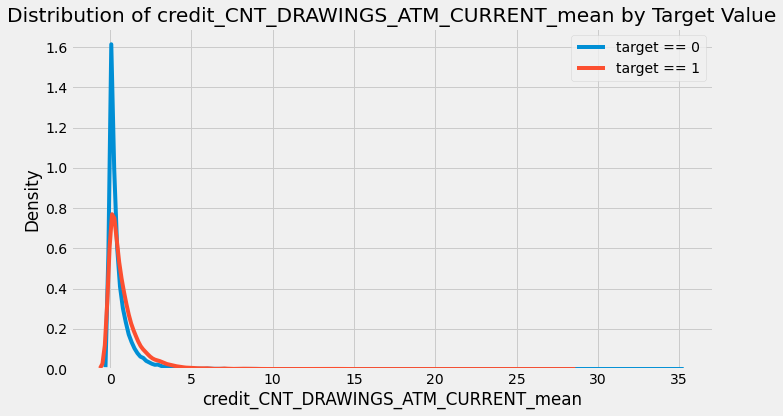

In [22]:
plot_kde('credit_CNT_DRAWINGS_ATM_CURRENT_mean', app_train)

In [23]:
# let's engineer some new features to merge to the train dataframe

# drawings in 1 year
cb_temp = credit_balance.loc[credit_balance['MONTHS_BALANCE'] >= -12]
cb_drawing_amt_1year = cb_temp.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].sum()
cb_cntdrawing_1year = cb_temp.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].sum()

# drawings in 6 months
cb_temp = credit_balance.loc[credit_balance['MONTHS_BALANCE'] >= -6]
cb_drawing_amt_6m = cb_temp.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].sum()
cb_cntdrawing_6m = cb_temp.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].sum()


In [24]:
# let's merge these features to the train dataset
app_train = app_train.merge(cb_drawing_amt_1year, on='SK_ID_CURR', how='left')
app_train = app_train.merge(cb_cntdrawing_1year, on='SK_ID_CURR', how='left')
app_train = app_train.merge(cb_drawing_amt_6m, on='SK_ID_CURR', how='left')
app_train = app_train.merge(cb_cntdrawing_6m, on='SK_ID_CURR', how='left')

In [25]:
# let's merge them to the test dataset
app_test = app_test.merge(cb_drawing_amt_1year, on='SK_ID_CURR', how='left')
app_test = app_test.merge(cb_cntdrawing_1year, on='SK_ID_CURR', how='left')
app_test = app_test.merge(cb_drawing_amt_6m, on='SK_ID_CURR', how='left')
app_test = app_test.merge(cb_cntdrawing_6m, on='SK_ID_CURR', how='left')

In [26]:
app_train.shape, app_test.shape

((307511, 454), (48744, 453))

## POS CASH BALANCE

In [27]:
cash_balance = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')

In [28]:
cash_balance = convert_types(cash_balance, print_info = True)
cash_balance.shape

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


(10001358, 8)

In [29]:
cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [30]:
cash_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [31]:
# let's encode the categorical features
cash_categorical = encode_categorical(cash_balance, 'SK_ID_CURR', 'cash')
cash_categorical.head()

,cash_NAME_CONTRACT_STATUS_XNA_mean,cash_NAME_CONTRACT_STATUS_XNA_sum,cash_NAME_CONTRACT_STATUS_Canceled_mean,cash_NAME_CONTRACT_STATUS_Canceled_sum,cash_NAME_CONTRACT_STATUS_Amortized debt_mean,cash_NAME_CONTRACT_STATUS_Amortized debt_sum,cash_NAME_CONTRACT_STATUS_Demand_mean,cash_NAME_CONTRACT_STATUS_Demand_sum,cash_NAME_CONTRACT_STATUS_Approved_mean,cash_NAME_CONTRACT_STATUS_Approved_sum,cash_NAME_CONTRACT_STATUS_Returned to the store_mean,cash_NAME_CONTRACT_STATUS_Returned to the store_sum,cash_NAME_CONTRACT_STATUS_Signed_mean,cash_NAME_CONTRACT_STATUS_Signed_sum,cash_NAME_CONTRACT_STATUS_Completed_mean,cash_NAME_CONTRACT_STATUS_Active_mean,cash_NAME_CONTRACT_STATUS_Completed_sum,cash_NAME_CONTRACT_STATUS_Active_sum,SK_ID_CURR
0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.222222,0.777778,2,7.0,100001
1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,1.000000,0,19.0,100002
2,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.071429,0.928571,2,26.0,100003
3,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.250000,0.750000,1,3.0,100004
4,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.090909,1,0.090909,0.818182,1,9.0,100005


In [32]:
cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [33]:
cash_tmp = cash_balance.drop(columns='SK_ID_PREV')
cols = cash_tmp.columns
cash_numeric = numeric_agg(cash_tmp, cols, 'SK_ID_CURR', 'cash')

In [34]:
cash_numeric.head()

,SK_ID_CURR,cash_MONTHS_BALANCE_count,cash_MONTHS_BALANCE_mean,cash_MONTHS_BALANCE_max,cash_MONTHS_BALANCE_min,cash_MONTHS_BALANCE_sum,cash_CNT_INSTALMENT_count,cash_CNT_INSTALMENT_mean,cash_CNT_INSTALMENT_max,cash_CNT_INSTALMENT_min,...,cash_SK_DPD_count,cash_SK_DPD_mean,cash_SK_DPD_max,cash_SK_DPD_min,cash_SK_DPD_sum,cash_SK_DPD_DEF_count,cash_SK_DPD_DEF_mean,cash_SK_DPD_DEF_max,cash_SK_DPD_DEF_min,cash_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107142,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0


In [35]:
# merge
cash_features = cash_numeric.merge(cash_categorical, on='SK_ID_CURR', how='inner')

del cash_numeric, cash_categorical
gc.collect()

3778

In [36]:
# merge to both train and test
app_train = app_train.merge(cash_features, on='SK_ID_CURR', how='left')
app_test = app_test.merge(cash_features, on='SK_ID_CURR', how='left')



del cash_features
gc.collect()

0

In [37]:
app_train.shape, app_test.shape

((307511, 497), (48744, 496))

## Previous Applications

In [38]:
prev_apps = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
prev_apps = convert_types(prev_apps, print_info = True)

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.24 gb.


In [39]:
prev_apps.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
prev_counts = prev_apps.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns={'SK_ID_PREV':'prev_appscnt'})
unique_counts = prev_apps.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].nunique().rename(columns={'SK_ID_PREV':'prev_appsunique'})

In [41]:
# statistical aggregates
prev_tmp = prev_apps.drop(columns=['SK_ID_PREV'])
cols = prev_tmp.columns
previous_numeric = numeric_agg(prev_tmp, cols, 'SK_ID_CURR', 'prev')

del prev_tmp
gc.collect()

0

In [42]:
previous_numeric.head()

,SK_ID_CURR,prev_AMT_ANNUITY_count,prev_AMT_ANNUITY_mean,prev_AMT_ANNUITY_max,prev_AMT_ANNUITY_min,prev_AMT_ANNUITY_sum,prev_AMT_APPLICATION_count,prev_AMT_APPLICATION_mean,prev_AMT_APPLICATION_max,prev_AMT_APPLICATION_min,...,prev_DAYS_TERMINATION_count,prev_DAYS_TERMINATION_mean,prev_DAYS_TERMINATION_max,prev_DAYS_TERMINATION_min,prev_DAYS_TERMINATION_sum,prev_NFLAG_INSURED_ON_APPROVAL_count,prev_NFLAG_INSURED_ON_APPROVAL_mean,prev_NFLAG_INSURED_ON_APPROVAL_max,prev_NFLAG_INSURED_ON_APPROVAL_min,prev_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [43]:
previous_categorical = encode_categorical(prev_apps, 'SK_ID_CURR', 'prev')

In [44]:
previous_categorical.head()

,prev_NAME_GOODS_CATEGORY_Animals_mean,prev_NAME_GOODS_CATEGORY_Animals_sum,prev_NAME_GOODS_CATEGORY_House Construction_mean,prev_NAME_GOODS_CATEGORY_House Construction_sum,prev_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,prev_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,prev_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,prev_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,prev_NAME_CASH_LOAN_PURPOSE_Hobby_mean,prev_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,prev_CODE_REJECT_REASON_XAP_mean,prev_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,prev_NAME_PORTFOLIO_POS_sum,prev_NAME_CONTRACT_TYPE_Consumer loans_sum,prev_NAME_CASH_LOAN_PURPOSE_XAP_sum,prev_NAME_PRODUCT_TYPE_XNA_sum,prev_NAME_CONTRACT_STATUS_Approved_sum,prev_CODE_REJECT_REASON_XAP_sum,prev_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,SK_ID_CURR
0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,100001
1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,100002
2,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,100003
3,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,100004
4,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,100005


In [45]:
prev_features = previous_numeric.merge(previous_categorical, on='SK_ID_CURR', how='inner')
columns = prev_features.columns

In [46]:
del previous_numeric, previous_categorical

gc.collect()

23

In [47]:
# let's merge to train and test dataframes
app_train = app_train.merge(prev_features, on='SK_ID_CURR', how='left')
app_train = app_train.merge(prev_counts,on='SK_ID_CURR', how='left')
app_train = app_train.merge(unique_counts, on='SK_ID_CURR', how='left')

app_test = app_test.merge(prev_features, on='SK_ID_CURR', how='left')
app_test = app_test.merge(prev_counts, on='SK_ID_CURR', how='left')
app_test = app_test.merge(unique_counts, on='SK_ID_CURR', how='left')

app_train.shape, app_test.shape

((307511, 878), (48744, 877))

In [51]:
# let's see the correlations of the new features added

corrs = app_train.corr()['TARGET']
corrs

SK_ID_CURR                               -0.002108
CNT_CHILDREN                              0.019187
AMT_INCOME_TOTAL                         -0.003982
AMT_CREDIT                               -0.030369
AMT_ANNUITY                              -0.012817
                                            ...   
prev_NAME_CONTRACT_STATUS_Approved_sum   -0.031553
prev_CODE_REJECT_REASON_XAP_sum          -0.011527
prev_FLAG_LAST_APPL_PER_CONTRACT_Y_sum    0.019333
prev_appscnt                              0.019762
prev_appsunique                           0.019762
Name: TARGET, Length: 860, dtype: float64

In [52]:
corrs = corrs.sort_values(ascending=False)
# most positive correlations
corrs.head(15)

TARGET                                        1.000000
credit_CNT_DRAWINGS_ATM_CURRENT_mean          0.107692
credit_CNT_DRAWINGS_CURRENT_max               0.101389
bureau_DAYS_CREDIT_mean                       0.093848
client_bb_balance_MONTHS_BALANCE_min_mean     0.089038
credit_AMT_BALANCE_mean                       0.087177
credit_AMT_TOTAL_RECEIVABLE_mean              0.086490
credit_AMT_RECIVABLE_mean                     0.086478
credit_AMT_RECEIVABLE_PRINCIPAL_mean          0.086062
credit_CNT_DRAWINGS_CURRENT_mean              0.082520
DAYS_BIRTH                                    0.078239
prev_NAME_CONTRACT_STATUS_Refused_mean        0.077671
bureau_CREDIT_ACTIVE_Active_mean              0.077356
client_bb_balance_MONTHS_BALANCE_mean_mean    0.076424
active_loan_counts                            0.076210
Name: TARGET, dtype: float64

In [53]:
# most negative correlations
corrs.tail(15)

prev_NAME_CONTRACT_STATUS_Approved_mean            -0.063521
client_bb_balance_MONTHS_BALANCE_count_max         -0.068792
prev_CODE_REJECT_REASON_XAP_mean                   -0.073930
bureau_CREDIT_ACTIVE_Closed_mean                   -0.079369
client_bb_balance_MONTHS_BALANCE_count_mean        -0.080193
EXT_SOURCE_1                                       -0.155317
EXT_SOURCE_2                                       -0.160472
EXT_SOURCE_3                                       -0.178919
bureau_CREDIT_DAY_OVERDUE_min                            NaN
bureau_CNT_CREDIT_PROLONG_min                            NaN
bureau_AMT_CREDIT_SUM_OVERDUE_min                        NaN
credit_SK_DPD_min                                        NaN
credit_SK_DPD_DEF_min                                    NaN
prev_NAME_GOODS_CATEGORY_House Construction_mean         NaN
prev_NAME_GOODS_CATEGORY_House Construction_sum          NaN
Name: TARGET, dtype: float64

In [54]:
del corrs, prev_features

gc.collect()

159

## Instalment Payments

In [55]:
instal_payments = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')
instal_payments = convert_types(instal_payments, print_info=True)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.65 gb.


In [56]:
instal_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


We have no categorical columns here so all we have to do is engineer the features based on the statistical aggregates and merge them to the train and test dataframes

In [57]:
instal_tmp = instal_payments.drop(columns=['SK_ID_PREV'])
cols = instal_tmp.columns

instal_features = numeric_agg(instal_tmp, cols, 'SK_ID_CURR', 'instal')
instal_features.head()

,SK_ID_CURR,instal_NUM_INSTALMENT_VERSION_count,instal_NUM_INSTALMENT_VERSION_mean,instal_NUM_INSTALMENT_VERSION_max,instal_NUM_INSTALMENT_VERSION_min,instal_NUM_INSTALMENT_VERSION_sum,instal_NUM_INSTALMENT_NUMBER_count,instal_NUM_INSTALMENT_NUMBER_mean,instal_NUM_INSTALMENT_NUMBER_max,instal_NUM_INSTALMENT_NUMBER_min,...,instal_AMT_INSTALMENT_count,instal_AMT_INSTALMENT_mean,instal_AMT_INSTALMENT_max,instal_AMT_INSTALMENT_min,instal_AMT_INSTALMENT_sum,instal_AMT_PAYMENT_count,instal_AMT_PAYMENT_mean,instal_AMT_PAYMENT_max,instal_AMT_PAYMENT_min,instal_AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,5885.132324,17397.900391,3951.000000,4.119593e+04,7,5885.132324,17397.900391,3951.000000,4.119593e+04
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,11559.247070,53093.746094,9251.775391,2.196257e+05,19,11559.247070,53093.746094,9251.775391,2.196257e+05
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,64754.585938,560835.375000,6662.970215,1.618865e+06,25,64754.585938,560835.375000,6662.970215,1.618865e+06
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,7096.154785,10573.964844,5357.250000,2.128846e+04,3,7096.154785,10573.964844,5357.250000,2.128846e+04
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,6240.205078,17656.244141,4813.200195,5.616184e+04,9,6240.205078,17656.244141,4813.200195,5.616184e+04


In [58]:
# let's merge these features to the train and test dataframes

app_train = app_train.merge(instal_features, on='SK_ID_CURR', how='left')
app_test = app_test.merge(instal_features, on='SK_ID_CURR', how='left')

app_train.shape, app_test.shape

((307511, 908), (48744, 907))

In [59]:
# In the first notebook, we engineered some features based on some limited domain knowledge

app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT']/app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY']/app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY']/app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED']/app_train['DAYS_BIRTH']

app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT']/app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY']/app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY']/app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED']/app_test['DAYS_BIRTH']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [60]:
app_train.shape, app_test.shape

((307511, 912), (48744, 911))

In [61]:
# let's save these dataframes

app_train.to_csv('train_raw.csv', index=False)
app_test.to_csv('test_raw.csv', index=False)

In [62]:
del app_train, app_test, instal_features, instal_tmp, instal_payments, prev_apps

gc.collect()

23

## Feature Selection

Since we have many features,we'll devise a means to remove the redundant features.

In [63]:
app_train = pd.read_csv('./train_raw.csv')
app_test = pd.read_csv('./test_raw.csv')

app_train.shape, app_test.shape

((307511, 912), (48744, 911))

Let's start by removing features with higher than 80% missing values. 

In [64]:
def missing_values_table(df):
    """Returns a dataframe of number of missing entries per column in df"""
    miss_val = df.isnull().sum()
    miss_val_percent = (100 * df.isnull().sum())/len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
    miss_val_table = miss_val_table.rename(columns={0:'Missing Values', 1:'% of Total Values'})
    
    # sort the table by missing
    miss_val_table = miss_val_table[miss_val_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # print some summary information
    print(f'The dataframe has {str(df.shape[1])} columns.\nThere are {str(miss_val_table.shape[0])} columns with missing values')
    return miss_val_table

In [66]:
missing_values_table(app_train)[:20]

The dataframe has 912 columns.
There are 855 columns with missing values


,Missing Values,% of Total Values
prev_RATE_INTEREST_PRIMARY_min,302902,98.5
prev_RATE_INTEREST_PRIVILEGED_min,302902,98.5
prev_RATE_INTEREST_PRIMARY_max,302902,98.5
prev_RATE_INTEREST_PRIMARY_mean,302902,98.5
prev_RATE_INTEREST_PRIVILEGED_max,302902,98.5
prev_RATE_INTEREST_PRIVILEGED_mean,302902,98.5
bureau_AMT_ANNUITY_max,247107,80.4
bureau_AMT_ANNUITY_mean,247107,80.4
bureau_AMT_ANNUITY_min,247107,80.4
credit_AMT_PAYMENT_CURRENT_min,246451,80.1


In [67]:
# fucntion to remove these features

def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [68]:
app_train, app_test = remove_missing_columns(app_train, app_test, threshold = 90)

There are 6 columns with greater than 90% missing values.


In [69]:
app_train.shape, app_test.shape

((307511, 906), (48744, 905))

In [70]:
missing_values_table(app_train)[:40]

The dataframe has 906 columns.
There are 849 columns with missing values


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,247107,80.4
bureau_AMT_ANNUITY_max,247107,80.4
bureau_AMT_ANNUITY_mean,247107,80.4
credit_AMT_PAYMENT_CURRENT_mean,246451,80.1
credit_AMT_PAYMENT_CURRENT_max,246451,80.1
credit_AMT_PAYMENT_CURRENT_min,246451,80.1
credit_AMT_DRAWINGS_OTHER_CURRENT_mean,246371,80.1
credit_AMT_DRAWINGS_ATM_CURRENT_max,246371,80.1
credit_AMT_DRAWINGS_ATM_CURRENT_min,246371,80.1
credit_CNT_DRAWINGS_OTHER_CURRENT_mean,246371,80.1


In [79]:
app_train.iloc[:, 120:140].head()

,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min
0,1.0,8.0,-874.00,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,6.0,-349.0,780.0,-1072.0,-2094.0,6.0,-697.500000,-36.0,-1185.0
1,0.0,4.0,-1400.75,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,4.0,-544.5,1216.0,-2434.0,-2178.0,3.0,-1097.333333,-540.0,-2131.0
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# here we decided to drop some features that might not contribute much

cols = ['OWN_CAR_AGE', 'ELEVATORS_AVG']
app_train = app_train.drop(columns=cols)
app_test = app_test.drop(columns=cols)

app_train.shape, app_test.shape

((307511, 904), (48744, 903))

Remove some features based on correlations

In [81]:
corrs = app_train.corr()['TARGET']
corrs = corrs.sort_values(ascending=False)

In [82]:
# let's see the most 15 most positive correlations
corrs.head(15)

TARGET                                        1.000000
credit_CNT_DRAWINGS_ATM_CURRENT_mean          0.107692
credit_CNT_DRAWINGS_CURRENT_max               0.101389
bureau_DAYS_CREDIT_mean                       0.093848
client_bb_balance_MONTHS_BALANCE_min_mean     0.089038
credit_AMT_BALANCE_mean                       0.087177
credit_AMT_TOTAL_RECEIVABLE_mean              0.086490
credit_AMT_RECIVABLE_mean                     0.086478
credit_AMT_RECEIVABLE_PRINCIPAL_mean          0.086062
credit_CNT_DRAWINGS_CURRENT_mean              0.082520
DAYS_BIRTH                                    0.078239
prev_NAME_CONTRACT_STATUS_Refused_mean        0.077671
bureau_CREDIT_ACTIVE_Active_mean              0.077356
client_bb_balance_MONTHS_BALANCE_mean_mean    0.076424
active_loan_counts                            0.076210
Name: TARGET, dtype: float64

In [83]:
# 15 most negative correlations
corrs.tail(15)

prev_NAME_CONTRACT_STATUS_Approved_mean            -0.063521
client_bb_balance_MONTHS_BALANCE_count_max         -0.068792
prev_CODE_REJECT_REASON_XAP_mean                   -0.073930
bureau_CREDIT_ACTIVE_Closed_mean                   -0.079369
client_bb_balance_MONTHS_BALANCE_count_mean        -0.080193
EXT_SOURCE_1                                       -0.155317
EXT_SOURCE_2                                       -0.160472
EXT_SOURCE_3                                       -0.178919
bureau_CREDIT_DAY_OVERDUE_min                            NaN
bureau_CNT_CREDIT_PROLONG_min                            NaN
bureau_AMT_CREDIT_SUM_OVERDUE_min                        NaN
credit_SK_DPD_min                                        NaN
credit_SK_DPD_DEF_min                                    NaN
prev_NAME_GOODS_CATEGORY_House Construction_mean         NaN
prev_NAME_GOODS_CATEGORY_House Construction_sum          NaN
Name: TARGET, dtype: float64

In [84]:
# let's remove some columns

cols = ['bureau_CREDIT_DAY_OVERDUE_min', 'bureau_CNT_CREDIT_PROLONG_min', 'bureau_AMT_CREDIT_SUM_OVERDUE_min', 
       'credit_SK_DPD_min', 'credit_SK_DPD_DEF_min', 'prev_NAME_GOODS_CATEGORY_House Construction_mean', 'prev_NAME_GOODS_CATEGORY_House Construction_sum']
app_train = app_train.drop(columns = cols)
app_test = app_test.drop(columns = cols)
app_train.shape, app_test.shape

((307511, 897), (48744, 896))

In [100]:
corrs[480:500]

prev_NAME_GOODS_CATEGORY_Office Appliances_sum                           0.000191
prev_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean                0.000121
prev_NAME_PAYMENT_TYPE_Non-cash from your account_sum                    0.000083
prev_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean    0.000058
credit_CNT_DRAWINGS_OTHER_CURRENT_max                                    0.000008
prev_NAME_GOODS_CATEGORY_Direct Sales_sum                               -0.000011
bureau_AMT_ANNUITY_mean                                                 -0.000078
prev_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum    -0.000191
prev_NAME_GOODS_CATEGORY_Office Appliances_mean                         -0.000236
prev_RATE_INTEREST_PRIVILEGED_count                                     -0.000237
prev_RATE_INTEREST_PRIMARY_count                                        -0.000237
prev_NAME_GOODS_CATEGORY_Weapon_sum                                     -0.000241
cash_NAME_CONTRA

In [101]:
cols = ['credit_CNT_DRAWINGS_OTHER_CURRENT_max', 'prev_NAME_GOODS_CATEGORY_Direct Sales_sum']

app_train = app_train.drop(columns=cols)
app_test = app_test.drop(columns=cols)

app_train.shape, app_test.shape

((307511, 895), (48744, 894))

In [102]:
del corrs

gc.collect()

46

### Let's Remove Collinear Features

In [103]:
corrs = app_train.corr()

In [104]:
threshold = 0.8

# dictionary to hold correlated features
above_threshold_features = {}

# record only correlations above the threshold
for col in corrs:
    above_threshold_features[col] = list(corrs.index[corrs[col] > threshold])

In [105]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_features.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  357


In [106]:
# let's remove the features

train_corrs_removed = app_train.drop(columns=cols_to_remove)
test_corrs_removed = app_test.drop(columns = cols_to_remove)

train_corrs_removed.shape, test_corrs_removed.shape

((307511, 538), (48744, 537))

In [107]:
# let's save
train_corrs_removed.to_csv('train_engineered.csv', index=False)
test_corrs_removed.to_csv('test_engineered.csv', index=False)

In [108]:
app_train.shape, app_test.shape

((307511, 895), (48744, 894))

In [109]:
# let's save these too

app_train.to_csv('train_engineeredtmp.csv', index=False)
app_test.to_csv('test_engineeredtmp.csv', index=False)